Comparison of Disaster tweets : 
The aim of this notebook is to classify tweets potentially related to catastrophes into real or misleading tweets. Here comparison between several ML techniques will be also done.

In [48]:
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt

import string
import nltk
import re # regular expressions

import time

In [49]:
#!pip install pyspellchecker

In [50]:
#from spellchecker import SpellChecker
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.linear_model import RidgeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB
from sklearn.feature_selection import SelectPercentile

# pip install xgboost
import xgboost
from xgboost import XGBClassifier

In [51]:
import spacy
from spacy.lang.en import English

In [76]:
import string

In [4]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\arijit\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [5]:
#!ls sample_data

In [6]:
#!cp test.csv train.csv sample_data

In [52]:
# training data
data = pd.read_csv('train.csv')
data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [53]:
train_len = len(data)

In [54]:
# test data
tdata = pd.read_csv('test.csv')
tdata.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [10]:
print('training data shape: {}, test data shape: {}'.format(data.shape, tdata.shape))

training data shape: (7613, 5), test data shape: (3263, 4)


In [55]:
#combine training & test data, but dont shuffale
total_data = pd.concat([data, tdata], sort=False)
total_data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1.0
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1.0
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1.0
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1.0
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1.0


In [56]:
# check the missing data 
total_data.isnull().sum()

id             0
keyword       87
location    3638
text           0
target      3263
dtype: int64

In [57]:
# so there are lot of missing values

In [58]:
print('unique values in keyword {}, location {}'.format(total_data.keyword.nunique(), total_data.location.nunique()))

unique values in keyword 221, location 4521


In [59]:
# check the distribution of target if there they are uneven 
def show_target_barplot():
  """ plot target distribution """
  target_types = data.target.value_counts()
  plot = sb.barplot(y=target_types, x=data.target.value_counts().index)
  plot.set_title('target distribution')

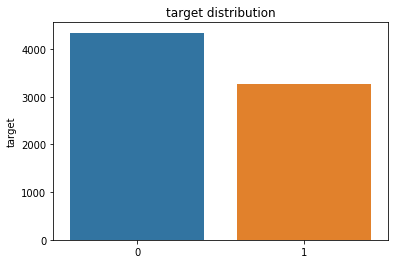

In [60]:
show_target_barplot()

'target' type counts looks to be not too deviated.

In [17]:
# Analyze the keyword & location feature and fill the missing values
def plot_keyword_location():
  fig, ax =plt.subplots(1,2)
  fig.subplots_adjust(hspace=0.5 , wspace=0.5)

  target_types = data.keyword.value_counts()[:10]
  # check for first few common names
  plot = sb.barplot(x=target_types, y=data.keyword.value_counts()[:10].index, ax=ax[0])
  plot.set_title('keyword types')

  location_types = data.location.value_counts()[:10]
  plot2 = sb.barplot(x=location_types, y=data.location.value_counts()[:10].index, ax=ax[1])
  plot2.set_title('location types')

  fig.show()

C:\Users\arijit\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:15: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  from ipykernel import kernelapp as app


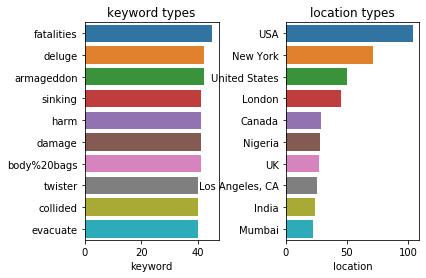

In [18]:
plot_keyword_location()

In [61]:
def fill_misiing_val():
  """ fill missing values with None """
  total_data.location.fillna('None', inplace=True)
  total_data.keyword.fillna('None', inplace=True)

  total_data.target.fillna(0, inplace=True)

fill_misiing_val()

In [62]:
total_data.isnull().sum()

id          0
keyword     0
location    0
text        0
target      0
dtype: int64

In [63]:
total_data.head()

,id,keyword,location,text,target
0,1,None,None,Our Deeds are the Reason of this #earthquake M...,1.0
1,4,None,None,Forest fire near La Ronge Sask. Canada,1.0
2,5,None,None,All residents asked to 'shelter in place' are ...,1.0
3,6,None,None,"13,000 people receive #wildfires evacuation or...",1.0
4,7,None,None,Just got sent this photo from Ruby #Alaska as ...,1.0


Data is now ready for cleaning

This data is having all weblinks and spaces as well
*   Need to clean the text *data*
*   remove punctuations
*   List item
*   lower case 
*   remove 







In [72]:
def remove_punctuations_and_nums(text):
  """ remove '!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~' and numbers """
  clean_data = ''.join([x for x in text if x not in string.punctuation])
  clean_data = ''.join([x for x in clean_data if x not in string.digits])
  return clean_data

def remove_stopwords(text):
  clean_data = ''.join([x for x in text if x not in nltk.corpus.stopwords.words('english')])
  return clean_data

def remove_weblinks(text):
  clean_data = re.sub('www.|https://|http://|.com|t.co/','', text)
  return clean_data

def remove_nonascii(text):
  clean_text = ''.join([x for x in text if ord(x) < 128])
  return clean_text

#spell = SpellChecker()
def correct_spelling(text):
  """ spelling correction """
  mispelled = spell.unknown(text.split())

  correct_text = []
  for word in text.split():
    if word in mispelled:
      correct_text.append(spell.correction(word))
    else:
      correct_text.append(word)

  return correct_text

def clean_text(data):
  # convert to lower case
  data['clean_text'] = data['text'].apply(lambda x: x.lower())
  print('lower case')
  # remove punc & digits
  data['clean_text'] = data['clean_text'].apply(lambda x: remove_punctuations_and_nums(x))
  # remove stopwords
  data['clean_text'] = data['clean_text'].apply(lambda x: remove_stopwords(x))
  # remove all web links
  data['clean_text'] = data['clean_text'].apply(lambda x: remove_weblinks(x)) # takes time
  # remove non ascii charecters
  data['clean_text'] = data['clean_text'].apply(lambda x: remove_nonascii(x))
  # removing any leading and trailing whitespaces including tabs
  #data['clean_text'] = data['clean_text'].apply(lambda x: x.strip())

  # correct spelling
  # data['clean_text'] = data['clean_text'].apply(lambda x: correct_spelling(x)) #takes time to process
  
  # Lemmatization TBD
  

In [89]:
clean_text(total_data)

lower case


In [90]:
total_data.head()

,id,keyword,location,text,target,clean_text
0,1,None,None,Our Deeds are the Reason of this #earthquake M...,1.0,ur ee re he ren f h erhquke llh frgve u ll
1,4,None,None,Forest fire near La Ronge Sask. Canada,1.0,fre fre ner l rnge k cn
2,5,None,None,All residents asked to 'shelter in place' are ...,1.0,ll reen ke heler n plce re beng nfe b ffcer n...
3,6,None,None,"13,000 people receive #wildfires evacuation or...",1.0,peple receve wlfre evcun rer n clfrn
4,7,None,None,Just got sent this photo from Ruby #Alaska as ...,1.0,ju g en h ph fr rub lk ke fr wlfre pur n chl


In [91]:
#save the cleaned data for future processing
total_data.to_csv('cleaned_data.csv')

In [92]:
# vectorize
def vectorize_text(text):
  # just skipping CountVectorizer 
  vec = TfidfVectorizer() #CountVectorizer() #TfidfVectorizer()
  vectorized_text = vec.fit_transform(text)
  return vec, vectorized_text

In [93]:
# Define a metrics function named get_metrics to evaluate the model's performance
def get_metrics(y_test, y_predicted):  
    # true positives / (true positives+false positives)
    precision = precision_score(y_test, y_predicted, pos_label=None,
                                    average='weighted')             
    # true positives / (true positives + false negatives)
    recall = recall_score(y_test, y_predicted, pos_label=None,
                              average='weighted')
    
    # harmonic mean of precision and recall
    f1 = f1_score(y_test, y_predicted, pos_label=None, average='weighted')
    
    # true positives + true negatives/ total
    accuracy = accuracy_score(y_test, y_predicted)
    return accuracy, precision, recall, f1

In [94]:
def scaled_data(X, X_valid):
    from sklearn.preprocessing import StandardScaler
    scaler_X = StandardScaler()
    X = scaler_X.fit_transform(X)
    X_valid = scaler_X.transform(X_valid)
    return X, X_valid, scaler_X  

In [95]:
"""
model_type : 
1 - Random forest(default)
2 - RidgeClassifier
3 - SVC
4 - Naive Bayes classifier
5 - xgboost 

TBD:
Parameter fine tuning
"""
#create a traditional sklearn model
def create_model(X, y, train_len, model_type=1):

  # split
  X_train = X[:train_len]
  X_test = X[train_len:]
  y_train = y[:train_len]
  y_test = y[train_len:]
  y_predict = []
  #X_train, X_test, y_train, y_test = train_test_split()
  # vectorize
  vec, X_train = vectorize_text(X_train)
  X_test = vec.transform(X_test)

  #X_Train, X_valid, scaler_X = scaled_data(X_train, X_test)
  #X_Test = scaler_X.transform(X_test)
    
  if model_type == 1: #RF classifier
    #model = RandomForestClassifier(n_estimators=100, random_state=21, max_depth=5)
    model = RandomForestClassifier(random_state=21)
    model.fit(X_train, y_train)
    cval = cross_val_score(model, X_train, y_train, scoring = 'balanced_accuracy', cv = 3)
    y_predict = model.predict(X_test)
    
  elif model_type == 2: #RidgeClassifier
    model = RidgeClassifier(random_state=21)
    model.fit(X_train, y_train)
    cval = cross_val_score(model, X_train, y_train, scoring = 'balanced_accuracy', cv = 3)
    y_predict = model.predict(X_test)
    
  elif model_type == 3: #SVC
    model = SVC(C=1.0, kernel='rbf',random_state=21)
    model.fit(X_train, y_train)
    cval = cross_val_score(model, X_train, y_train, scoring = 'balanced_accuracy', cv = 3)
    y_predict = model.predict(X_test)
    
  elif model_type == 4: #Naive Bayes classifier
    model = GaussianNB()

    X_train_transform = X_train.toarray()
    X_test_transform = X_test.toarray()
    
    model.fit(X_train_transform, y_train)
    y_predict = model.predict(X_test_transform)
    cval = cross_val_score(model, X_train_transform, y_train, scoring = 'balanced_accuracy', cv = 3)
    
  elif model_type == 5: # xgboost classifier
    model = XGBClassifier()
    model.fit(X_train, y_train)
    cval = cross_val_score(model, X_train, y_train, scoring = 'balanced_accuracy', cv = 3)
    y_predict = model.predict(X_test)
    
  print("cross validation score:{}".format(cval))
  #accuracy, precision, recall, f1 = get_metrics(y_test, y_predict)  
  #print("accuracy {}, precision {}, recall {}, f1 {}".format(accuracy, precision, recall, f1))
  
  return y_predict

In [96]:
#read the saved data 
df = pd.read_csv('cleaned_data.csv')
X = df['clean_text']
y = df['target']

from datetime import datetime
time_start = datetime.now()

y_predict = create_model(X, y, train_len, 1) # random forest

#y_predict = create_model(X, y, train_len, 2) #RidgeClassifier

#y_predict = create_model(X, y, train_len, 3) #svc

#y_predict = create_model(X, y, train_len, 4) # naive bayes

#y_predict = create_model(X, y, train_len, 5) #xgboost 

time_delta = datetime.now()-time_start
print('time:',time_delta)

cross validation score:[0.65788252 0.61195765 0.65697932]
time: 0:00:52.268807


In [97]:
#write the predictions to a file
predict = pd.DataFrame({'text':tdata['text'], 'prediction':y_predict})
predict.to_csv('final_prediction.csv')


*Use SpaCy*
spacy has preloaded english library and it understand the stop words etc.

In [8]:
spacy_nlp = spacy.load('en_core_web_lg')

In [ ]:
# remove stop words
def rem_stopw(text):
    clean_text = "".join()

In [3]:
print('spaCy Version: %s' % (spacy.__version__))

spaCy Version: 2.2.3


In [4]:
spacy_stopw = spacy.lang.en.STOP_WORDS

In [130]:
def remove_stopw(text):
    tokens = [token.text for token in text if not token.is_stop]
    return ' '.join([token for token in tokens])

def text_lammatize(text):
    tokens = [token.lemma_ for token in text]
    return ' '.join([token for token in tokens])

def remove_punctuations(text):
    punctuations = string.punctuation
    tokens = [word for word in text if not punctuations]
    return tokens
#' '.join([token for token in tokens])

In [140]:
spacy_tokenizer(sample_text)

['computing',
 'stop',
 'words',
 'words',
 'filtered',
 'processing',
 'natural',
 'language',
 'data']

def clean_text_spacy(df):
    df['clean_text'] = df['text'].apply(lambda x: x.lower())
    df['clean_text'] = df['clean_text'].apply(lambda x: remove_stopw(spacy_nlp(x)))
    df['clean_text'] = df['clean_text'].apply(lambda x: text_lammatize(spacy_nlp(x)))
    df['clean_text'] = df['clean_text'].apply(lambda x: remove_weblinks(x))                

clean_text_spacy(total_data)

In [144]:
from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin

In [147]:
punctuations = string.punctuation

perser = English()

from spacy.lang.en.stop_words import STOP_WORDS
stopwords = list(STOP_WORDS)

def spacy_tokenizer(string):
    mtoken = perser(string) 
    #lammatization 
    mtoken = [word.lemma_.lower() if word.lemma_ != "-PRON-" else word.lower_ for word in mtoken]
    # remove stop words and punctuations
    mtoken = [word for word in mtoken if word not in stopwords and word not in punctuations]
    
    return mtoken

In [145]:
#Custom transformer using spaCy 
def clean_text(text):
    """Basic function to clean the text"""
    return text.strip().lower()
    

class predictors(TransformerMixin):
    def transform(self, X, **transform_params):
        print('predictors->transform')
        return [clean_text(text) for text in X]
    def fit(self, X, y=None, **fit_params):
        print('predictors->fit')
        return self
    def get_params(self, deep=True):
        return {}

In [146]:
classifier = RandomForestClassifier(random_state=21)
tfvenctorizer = TfidfVectorizer(tokenizer=spacy_tokenizer)

pipe = Pipeline([('cleaner', predictors()),
                ('vectorizer', tfvenctorizer),
                ('classifier', classifier)
                ])

In [148]:
X_train = data['text']
y_train = data['target']
pipe.fit(X_train, y_train)

predictors->fit
predictors->transform


Pipeline(memory=None,
         steps=[('cleaner', <__main__.predictors object at 0x000002DCDA29F148>),
                ('vectorizer',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop...
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=None, max_features='auto',
                                        max_leaf_nodes=None, max_samples=None,
                                        min_im

In [149]:
X_test = tdata['text']
prediction = pipe.predict(X_test)

predictors->transform


In [152]:
# create a csv for the predictions
pred = pd.DataFrame({'text':X_test, 'prediction':prediction})

In [153]:
pred.to_csv('pred_spacy.csv')